In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import os
from datetime import datetime
from dotenv import load_dotenv

load_dotenv()

df = pd.read_csv('/home/elbaz/Bureau/netflix_movies_single_genre.csv')

df.head()

,Unnamed: 0,id,title,type,description,release_year,age_certification,runtime,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,genre
0,0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['US'],1.0,NaN,NaN,NaN,0.600,NaN,documentation
1,1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179,crime
2,2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300,action
3,3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811,comedy
4,4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600,war


In [2]:
# df information general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            5791 non-null   int64  
 1   id                    5791 non-null   object 
 2   title                 5791 non-null   object 
 3   type                  5791 non-null   object 
 4   description           5781 non-null   object 
 5   release_year          5791 non-null   int64  
 6   age_certification     3204 non-null   object 
 7   runtime               5791 non-null   int64  
 8   production_countries  5791 non-null   object 
 9   seasons               2081 non-null   float64
 10  imdb_id               5438 non-null   object 
 11  imdb_score            5362 non-null   float64
 12  imdb_votes            5348 non-null   float64
 13  tmdb_popularity       5709 non-null   float64
 14  tmdb_score            5507 non-null   float64
 15  genre                

# Task 1: Identify the release year with the largest number of movies

Release year with the largest number of movies: 2019
Number of movies in 2019: 829

Top 10 years with most movies:
release_year
1945    1
1954    2
1956    1
1958    1
1959    1
1960    1
1961    1
1963    1
1966    1
1967    2
Name: count, dtype: int64


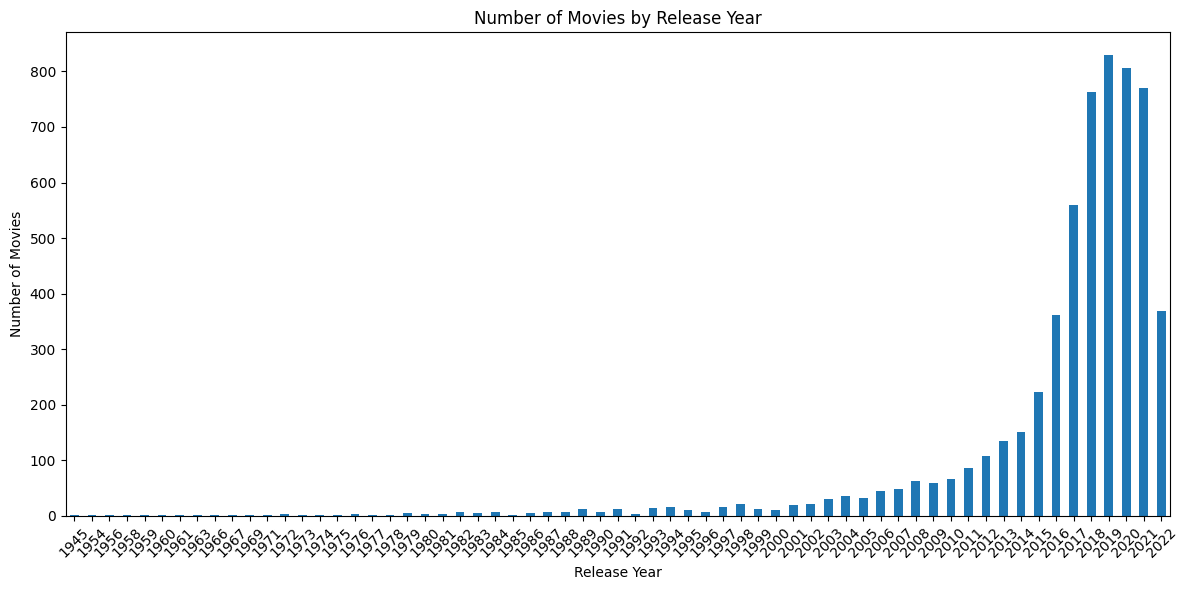

In [3]:
# Count movies by release year
year_counts = df['release_year'].value_counts().sort_index()

# Find the year with the most movies
most_movies_year = year_counts.idxmax()
most_movies_count = year_counts.max()

print(f"Release year with the largest number of movies: {most_movies_year}")
print(f"Number of movies in {most_movies_year}: {most_movies_count}")

# Display top 10 years with most movies
print("\nTop 10 years with most movies:")
print(year_counts.head(10))


plt.figure(figsize=(12, 6))
year_counts.plot(kind='bar')
plt.title('Number of Movies by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() 

# Task 2: For each release year, identify the most frequently represented movie genre

Most frequently represented movie genre for each release year:
 release_year         genre  count
         1945 documentation      1
         1954         drama      1
         1956         drama      1
         1958         drama      1
         1959         crime      1
         1960      thriller      1
         1961           war      1
         1963           war      1
         1966       western      1
         1967         crime      1
         1969        comedy      1
         1971      thriller      1
         1972        action      1
         1973      thriller      1
         1974        comedy      1
         1975        comedy      1
         1976         crime      1
         1977       history      1
         1978         drama      1
         1979        comedy      2
         1980       romance      2
         1981       romance      1
         1982         drama      4
         1983        family      2
         1984         crime      2
         1985        comedy

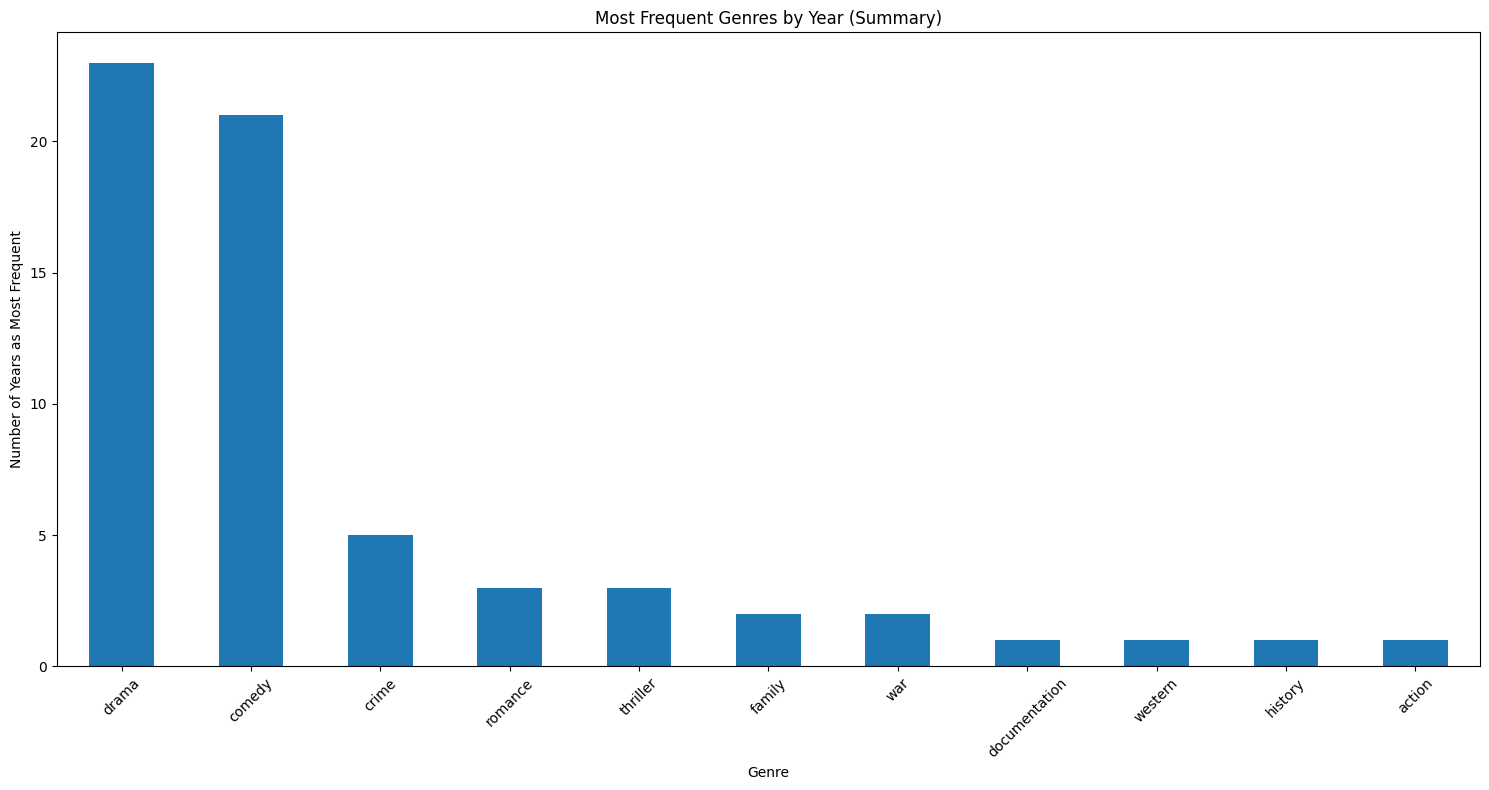

In [4]:
# Group by release year and genre, then count occurrences
genre_by_year = df.groupby(['release_year', 'genre']).size().reset_index(name='count')

# Find the most frequent genre for each year
most_frequent_genre_by_year = genre_by_year.loc[genre_by_year.groupby('release_year')['count'].idxmax()]

# Sort by release year
most_frequent_genre_by_year = most_frequent_genre_by_year.sort_values('release_year')

print("Most frequently represented movie genre for each release year:")
print(most_frequent_genre_by_year[['release_year', 'genre', 'count']].to_string(index=False))

# Display summary statistics
print(f"\nTotal number of years analyzed: {len(most_frequent_genre_by_year)}")
print(f"Most common genre overall: {most_frequent_genre_by_year['genre'].mode().iloc[0]}")

# Optional: Create a visualization
plt.figure(figsize=(15, 8))
genre_counts = most_frequent_genre_by_year['genre'].value_counts()
genre_counts.plot(kind='bar')
plt.title('Most Frequent Genres by Year (Summary)')
plt.xlabel('Genre')
plt.ylabel('Number of Years as Most Frequent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Task 3: Train and evaluate a model that predicts movie genre from movie description

Genre distribution:
genre
drama            1204
comedy           1049
romance           528
crime             446
documentation     363
thriller          330
action            261
family            260
horror            246
scifi             182
reality           167
music             152
animation         151
history           105
war                98
sport              96
fantasy            68
european           64
western            11
Name: count, dtype: int64

Number of movies after filtering: 5770
Number of unique genres: 18

Training set size: 4616
Test set size: 1154

Extracting features using TF-IDF...
Feature matrix shape: (4616, 2000)

Training classifier with balanced class weights...
Class weights:
  action: 1.227
  animation: 2.119
  comedy: 0.306
  crime: 0.718
  documentation: 0.884
  drama: 0.266
  european: 5.028
  family: 1.233
  fantasy: 4.749
  history: 3.053
  horror: 1.302
  music: 2.102
  reality: 1.914
  romance: 0.608
  scifi: 1.756
  sport: 3.330
  thriller:

/home/elbaz/Bureau/tmdb_data_eda/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elbaz/Bureau/tmdb_data_eda/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/elbaz/Bureau/tmdb_data_eda/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

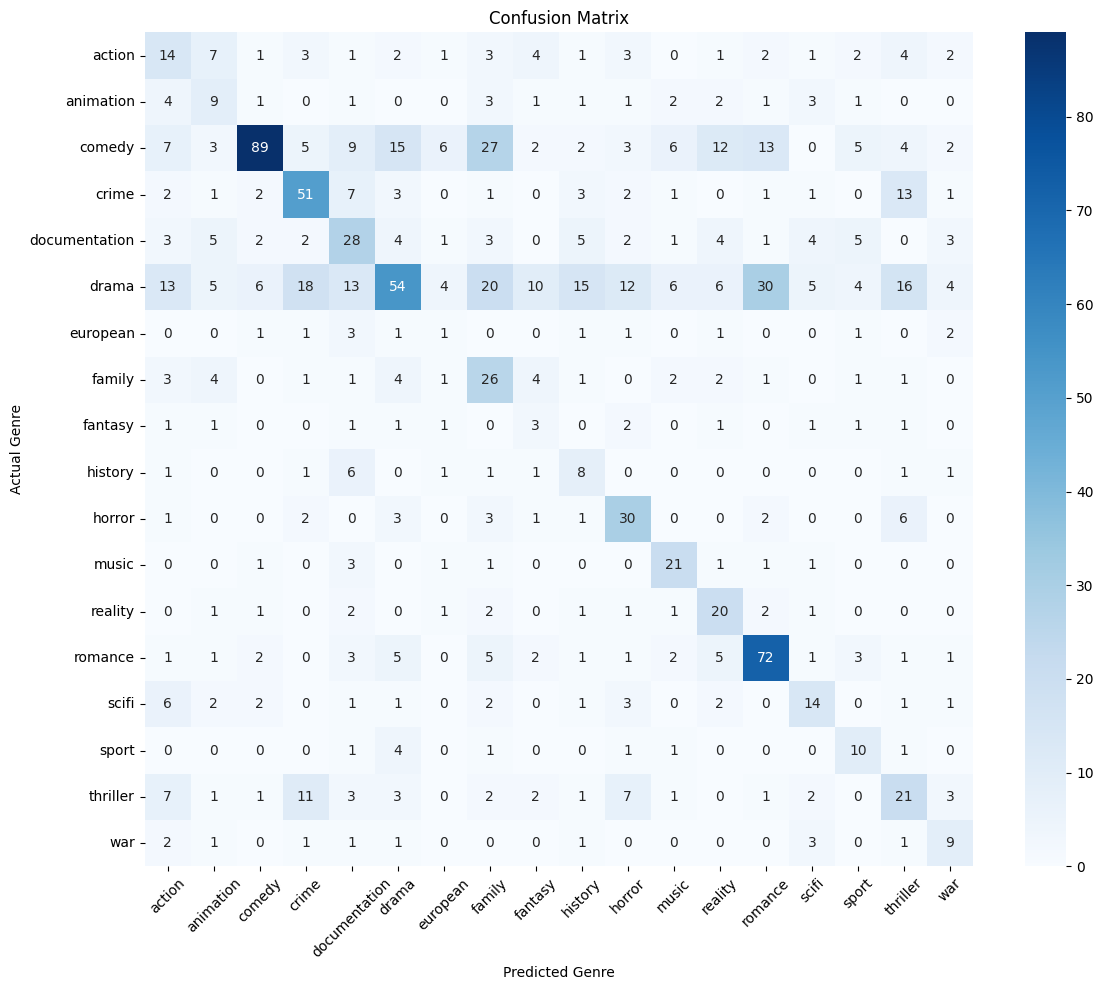


Example Predictions:

Example 1:
Description: When a soccer club manager brings one of his injured foreign players home to recuperate, they form a...
Actual Genre: sport
Predicted Genre: sport
Correct: ✓

Example 2:
Description: Asian American creatives pay passionate tribute to the iconic, stereotype-busting "Baby-Sitters Club...
Actual Genre: documentation
Predicted Genre: documentation
Correct: ✓

Example 3:
Description: Comedian George Lopez tackles the future and the past of Latinx culture in America, touching on immi...
Actual Genre: comedy
Predicted Genre: comedy
Correct: ✓

Example 4:
Description: A father and daughter live a perfect but mysterious existence in Forest Park, a beautiful nature res...
Actual Genre: drama
Predicted Genre: fantasy
Correct: ✗

Example 5:
Description: Following a ridiculously awful flight that leads to his pet's death, Nashawn Wade files a lawsuit ag...
Actual Genre: comedy
Predicted Genre: crime
Correct: ✗

Example 6:
Description: Friends, associat

/home/elbaz/Bureau/tmdb_data_eda/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [5]:


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight


# Data preprocessing
# Remove rows with missing descriptions
df_clean = df.dropna(subset=['description'])

# Check genre distribution
print("Genre distribution:")
print(df_clean['genre'].value_counts())

# Keep only genres with sufficient samples (at least 20 movies)
genre_counts = df_clean['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= 20].index
df_filtered = df_clean[df_clean['genre'].isin(valid_genres)]

print(f"\nNumber of movies after filtering: {len(df_filtered)}")
print(f"Number of unique genres: {df_filtered['genre'].nunique()}")

# Prepare features and labels
X = df_filtered['description']  # Features: movie descriptions
y = df_filtered['genre']        # Labels: genres

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Feature extraction using TF-IDF
print("\nExtracting features using TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=2000,  # Limit features to prevent overfitting
    stop_words='english',
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=2,  # Minimum document frequency
    max_df=0.95  # Maximum document frequency
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Feature matrix shape: {X_train_tfidf.shape}")

# Train a classifier with class weights to handle imbalanced data
print("\nTraining classifier with balanced class weights...")
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:")
for genre, weight in class_weight_dict.items():
    print(f"  {genre}: {weight:.3f}")

# Use Logistic Regression with balanced class weights
lr_classifier = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    random_state=42,
    solver='lbfgs'  # Good for small datasets
)
lr_classifier.fit(X_train_tfidf, y_train)

# Also train Naive Bayes for comparison
nb_classifier = MultinomialNB(class_prior=class_weights)
nb_classifier.fit(X_train_tfidf, y_train)

# Make predictions with both models
y_pred_nb = nb_classifier.predict(X_test_tfidf)
y_pred_lr = lr_classifier.predict(X_test_tfidf)

# Evaluate both models
print("\nModel Evaluation:")
print("=" * 50)

print("\n1. NAIVE BAYES (Original):")
print("-" * 30)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {accuracy_nb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

print("\n2. LOGISTIC REGRESSION (with class weights):")
print("-" * 40)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {accuracy_lr:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Compare overall performance
print("\n3. MODEL COMPARISON:")
print("-" * 20)
print(f"Naive Bayes Accuracy:     {accuracy_nb:.4f}")
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print(f"Improvement:              {accuracy_lr - accuracy_nb:.4f}")

# Use the better model for further analysis
if accuracy_lr > accuracy_nb:
    print("\nUsing Logistic Regression for further analysis...")
    y_pred = y_pred_lr
    best_classifier = lr_classifier
else:
    print("\nUsing Naive Bayes for further analysis...")
    y_pred = y_pred_nb
    best_classifier = nb_classifier

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('Actual Genre')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show some example predictions
print("\nExample Predictions:")
print("=" * 50)
sample_indices = np.random.choice(len(X_test), min(10, len(X_test)), replace=False)

for i, idx in enumerate(sample_indices):
    actual_genre = y_test.iloc[idx]
    predicted_genre = y_pred[idx]
    description = X_test.iloc[idx][:100] + "..."  # Truncate for display
    
    print(f"\nExample {i+1}:")
    print(f"Description: {description}")
    print(f"Actual Genre: {actual_genre}")
    print(f"Predicted Genre: {predicted_genre}")
    print(f"Correct: {'✓' if actual_genre == predicted_genre else '✗'}")

# Feature importance (top words for each genre)
print("\nTop words for each genre:")
print("=" * 50)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Show feature importance based on the best classifier
if 'best_classifier' in locals() and hasattr(best_classifier, 'coef_'):
    # For Logistic Regression, use coefficients
    print("Feature importance from Logistic Regression coefficients:")
    for i, genre in enumerate(sorted(y_train.unique())):
        if i < len(best_classifier.coef_):
            coef = best_classifier.coef_[i]
            top_indices = np.argsort(coef)[-10:]  # Top 10 words
            top_words = [feature_names[j] for j in top_indices]
            print(f"\n{genre}: {', '.join(reversed(top_words))}")
else:
    # Fallback to TF-IDF based approach
    print("Feature importance based on TF-IDF averages:")
    for genre in sorted(y_train.unique()):
        genre_indices = (y_train == genre).values  # Convert to numpy array
        if genre_indices.sum() > 0:
            genre_tfidf = X_train_tfidf[genre_indices].mean(axis=0).A1
            top_indices = np.argsort(genre_tfidf)[-10:]  # Top 10 words
            top_words = [feature_names[i] for i in top_indices]
            print(f"\n{genre}: {', '.join(reversed(top_words))}")

# Additional analysis: Show per-class performance improvement
print("\n\nPer-class performance comparison:")
print("=" * 50)
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, f1 for both models
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(y_test, y_pred_nb, average=None, labels=sorted(y_test.unique()))
precision_lr, recall_lr, f1_lr, _ = precision_recall_fscore_support(y_test, y_pred_lr, average=None, labels=sorted(y_test.unique()))

print(f"{'Genre':<15} {'NB F1':<8} {'LR F1':<8} {'Improvement':<12}")
print("-" * 50)
for i, genre in enumerate(sorted(y_test.unique())):
    if i < len(f1_nb) and i < len(f1_lr):
        improvement = f1_lr[i] - f1_nb[i]
        print(f"{genre:<15} {f1_nb[i]:<8.3f} {f1_lr[i]:<8.3f} {improvement:<12.3f}") 

In [6]:






uri = os.getenv("CONNECTION_STR_MONGODB")

# Create a new client and connect to the server
client = MongoClient(uri, server_api=ServerApi('1'))

# Send a ping to confirm a successful connection
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)

Pinged your deployment. You successfully connected to MongoDB!


# MongoDB connection

In [7]:
db = client["netflix_movies"]
collection = db["poor_predictions"]
print("✅ Connected to MongoDB!")

#Create test data with predictions
test_indices = y_test.index
test_data = df_filtered.loc[test_indices].copy()
test_data['actual_genre'] = y_test.values
test_data['predicted_genre_lr'] = y_pred_lr

#Find poor predictions
test_data['lr_correct'] = test_data['actual_genre'] == test_data['predicted_genre_lr']

poor_lr = test_data[~test_data['lr_correct']]

print(f"📊 Poor predictions found:")
print(f"   - Logistic Regression: {len(poor_lr)} movies")

# Analyze poor predictions
print(f"\n🔍 Top genres with poor predictions (Logistic Regression):")
genre_errors = poor_lr['actual_genre'].value_counts()
print(genre_errors.head(10))

print(f"\n🔍 Most common misclassifications (Logistic Regression):")
misclass = poor_lr.groupby(['actual_genre', 'predicted_genre_lr']).size().sort_values(ascending=False)
print(misclass.head(10))


#Prepare and upload documents
documents = []

for idx, row in poor_lr.iterrows():
    doc = {
        'movie_id': row['id'],
        'title': row['title'],
        'actual_genre': row['actual_genre'],
        'predicted_genre': row['predicted_genre_lr'],
        'model_name': 'Logistic Regression',
        'description': row['description'],
        'description_length': len(row['description']),
        'release_year': row['release_year'],
        'runtime': row['runtime'],
        'imdb_score': row['imdb_score'],
        'tmdb_score': row['tmdb_score'],
        'production_countries': row['production_countries'],
        'upload_timestamp': datetime.now(),
        'analysis_metadata': {
            'total_test_samples': len(poor_lr),
            'model_accuracy': 'poor_performance',
            'dataset_source': 'netflix_movies'
        }
    }
    documents.append(doc)

#Upload to MongoDB
result = collection.insert_many(documents)
print(f"✅ Uploaded {len(result.inserted_ids)} documents to MongoDB!")

# Create indexes for better performance
collection.create_index([("actual_genre", 1)])
collection.create_index([("model_name", 1)])
collection.create_index([("upload_timestamp", 1)])

print(f"📊 Total documents in collection: {collection.count_documents({})}")

# Close connection
client.close()
print("🔌 MongoDB connection closed.") 

✅ Connected to MongoDB!
📊 Poor predictions found:
   - Logistic Regression: 674 movies

🔍 Top genres with poor predictions (Logistic Regression):
actual_genre
drama            187
comedy           121
documentation     45
thriller          45
action            38
crime             38
romance           34
family            26
scifi             22
animation         21
Name: count, dtype: int64

🔍 Most common misclassifications (Logistic Regression):
actual_genre  predicted_genre_lr
drama         romance               30
comedy        family                27
drama         family                20
              crime                 18
              thriller              16
              history               15
comedy        drama                 15
drama         documentation         13
crime         thriller              13
comedy        romance               13
dtype: int64
✅ Uploaded 674 documents to MongoDB!
📊 Total documents in collection: 1348
🔌 MongoDB connection closed.


# Additional Anlysis

In [8]:
df.type.value_counts()

type
MOVIE    3710
SHOW     2081
Name: count, dtype: int64

In [9]:
df[['type', 'age_certification']].value_counts()

type   age_certification
SHOW   TV-MA                878
MOVIE  R                    553
SHOW   TV-14                470
MOVIE  PG-13                450
       PG                   233
SHOW   TV-PG                183
MOVIE  G                    121
SHOW   TV-Y7                118
       TV-Y                 104
       TV-G                  78
MOVIE  NC-17                 16
Name: count, dtype: int64

=== PRODUCTION COUNTRIES OVERVIEW ===
Total unique production countries: 450

Top 10 most common production countries:
production_countries
['US']    1943
['IN']     598
['JP']     262
['KR']     218
['GB']     218
[]         206
['ES']     161
['FR']     125
['CA']     106
['MX']      98
Name: count, dtype: int64


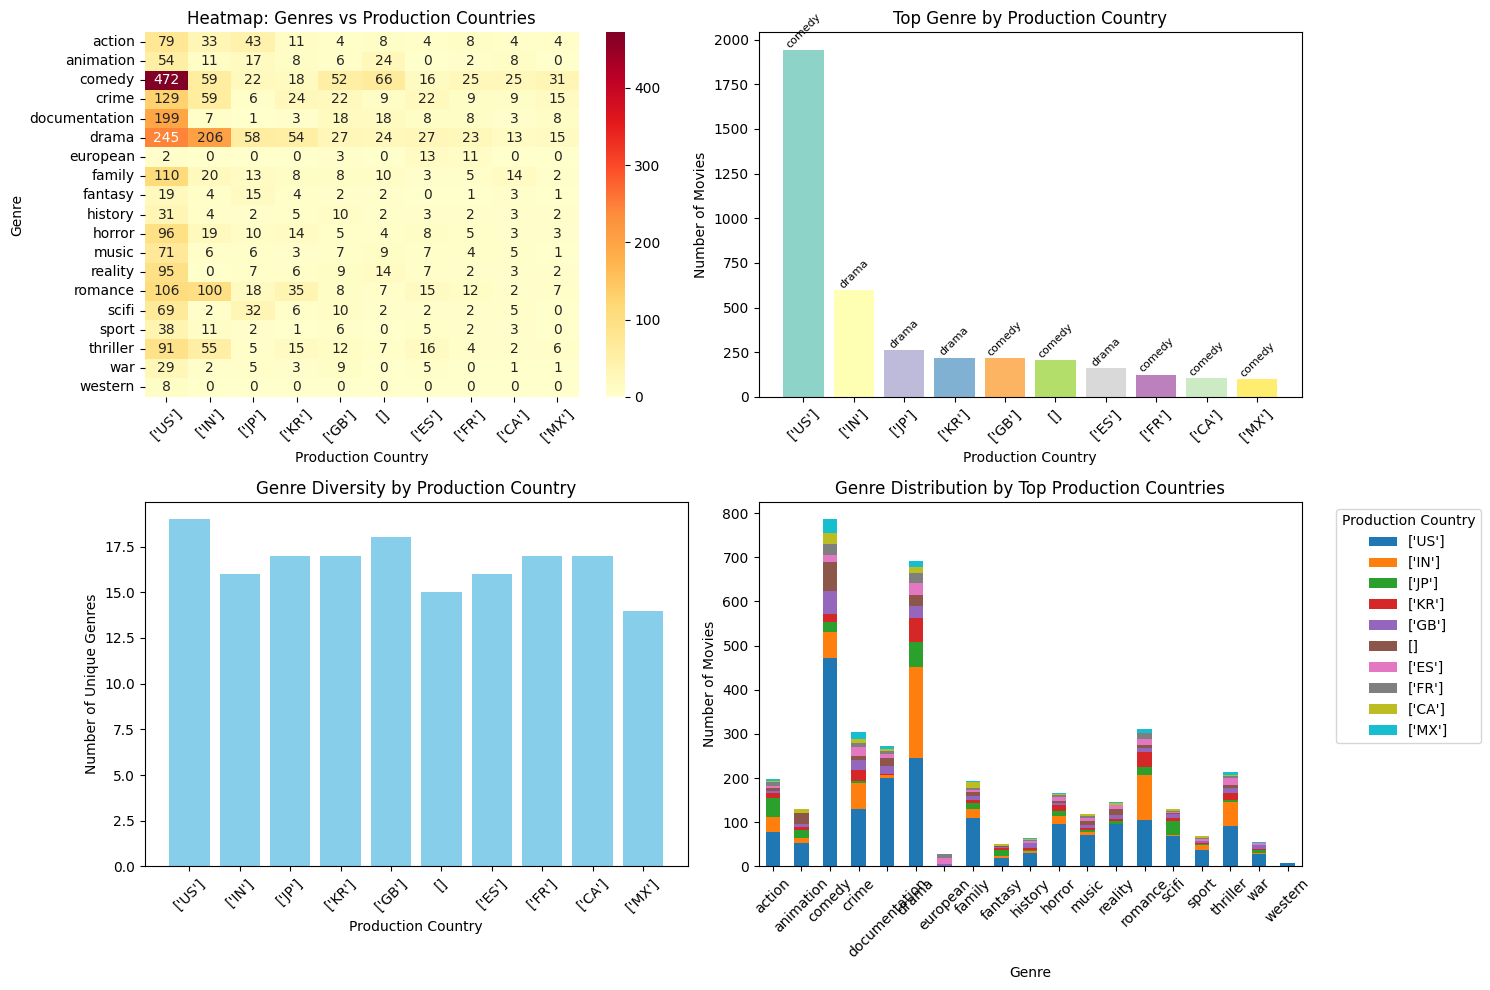


=== STATISTICAL ANALYSIS ===
Chi-square test for independence:
Chi-square statistic: 1232.50
P-value: 0.000000
✅ Significant relationship between genres and production countries

=== INTERESTING INSIGHTS ===
🎬 ['IN']: 34.4% of movies are drama
🎬 []: 32.0% of movies are comedy
🎬 ['MX']: 31.6% of movies are comedy

Genres overrepresented in specific countries:
🎭 documentation: 54.7% of movies are from ['US']
🎭 western: 72.7% of movies are from ['US']
🎭 reality: 56.2% of movies are from ['US']


In [10]:
print("=== PRODUCTION COUNTRIES OVERVIEW ===")
print(f"Total unique production countries: {df['production_countries'].nunique()}")

# Show most common production countries
print("\nTop 10 most common production countries:")
country_counts = df['production_countries'].value_counts().head(10)
print(country_counts)

# Get top 10 production countries
top_countries = df['production_countries'].value_counts().head(10).index

# Create cross-tabulation
genre_country_crosstab = pd.crosstab(df['genre'], df['production_countries'])


# Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(genre_country_crosstab[top_countries], annot=True, fmt='d', cmap='YlOrRd')
plt.title('Heatmap: Genres vs Production Countries')
plt.xlabel('Production Country')
plt.ylabel('Genre')
plt.xticks(rotation=45)

# Plot 2: Top genre for each country
plt.subplot(2, 2, 2)
country_genre_data = []
for country in top_countries:
    country_movies = df[df['production_countries'] == country]
    top_genre = country_movies['genre'].mode().iloc[0]
    count = len(country_movies)
    country_genre_data.append({'Country': country, 'Top Genre': top_genre, 'Count': count})

country_genre_df = pd.DataFrame(country_genre_data)
colors = plt.cm.Set3(np.linspace(0, 1, len(country_genre_df)))
bars = plt.bar(country_genre_df['Country'], country_genre_df['Count'], color=colors)
plt.title('Top Genre by Production Country')
plt.xlabel('Production Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)

# Add genre labels on bars
for i, (bar, row) in enumerate(zip(bars, country_genre_df.iterrows())):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             row[1]['Top Genre'], ha='center', va='bottom', rotation=45, fontsize=8)

# Plot 3: Genre diversity by country
plt.subplot(2, 2, 3)
genre_diversity = []
for country in top_countries:
    country_movies = df[df['production_countries'] == country]
    diversity = country_movies['genre'].nunique()
    genre_diversity.append({'Country': country, 'Genre Diversity': diversity})

diversity_df = pd.DataFrame(genre_diversity)
plt.bar(diversity_df['Country'], diversity_df['Genre Diversity'], color='skyblue')
plt.title('Genre Diversity by Production Country')
plt.xlabel('Production Country')
plt.ylabel('Number of Unique Genres')
plt.xticks(rotation=45)

# Plot 4: Stacked bar chart
plt.subplot(2, 2, 4)
genre_country_crosstab[top_countries].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Genre Distribution by Top Production Countries')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.legend(title='Production Country', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Statistical test
print("\n=== STATISTICAL ANALYSIS ===")
from scipy.stats import chi2_contingency

# Create contingency table for top countries and genres
contingency_table = genre_country_crosstab[top_countries].fillna(0)
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square test for independence:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"P-value: {p_value:.6f}")

if p_value < 0.05:
    print("✅ Significant relationship between genres and production countries")
else:
    print("❌ No significant relationship found")

# Interesting insights
print("\n=== INTERESTING INSIGHTS ===")

# Countries with genre preferences
for country in top_countries:
    country_movies = df[df['production_countries'] == country]
    if len(country_movies) >= 10:
        genre_distribution = country_movies['genre'].value_counts(normalize=True)
        most_common_genre = genre_distribution.index[0]
        percentage = genre_distribution.iloc[0] * 100
        
        if percentage > 30:
            print(f"🎬 {country}: {percentage:.1f}% of movies are {most_common_genre}")

# Genres overrepresented in specific countries
print("\nGenres overrepresented in specific countries:")
for genre in df['genre'].unique():
    genre_movies = df[df['genre'] == genre]
    if len(genre_movies) >= 5:
        country_distribution = genre_movies['production_countries'].value_counts(normalize=True)
        most_common_country = country_distribution.index[0]
        percentage = country_distribution.iloc[0] * 100
        
        if percentage > 50:
            print(f"🎭 {genre}: {percentage:.1f}% of movies are from {most_common_country}") 